In [1]:
# Analysis for comets observed by WISE
#
# Comet orbits are obtained by querying JPL Horizons for a set of all known cometary orbits
# JPL fits comet orbits typically on each apparation of the orbit, so comets such as 1P have
# *many* orbit fits, in some cases going back millenia. Many of these orbits, especially the
# older ones, have poor observational data, and as a result have extremely poor orbit fits.
# 
# Steps in this analysis:
# 1) Query horizons for the known set of cometary orbits, the result of this is saved in the
#    "jpl_comets.csv" file, which defines JPL's knowledge of all known comets, and the epochs
#    of the orbit fits. This is considered the master list of all cometary names.
# 2) Down select this list to only contain orbit epoch fits which obey the following criterion:
#       a) Epoch of orbit fit is after 1980
#       b) Name does not include "D/" for destroyed comets
#       c) The standard deviation of position knowledge is greater than 0.01 AU
#       d) during the period of WISE, from cryo through end of 2023, the comet at some point
#          must be closer than 11.5 AU from the sun. (See figure below for a histogram of this)
#       e) Explicity exclude 5 objects observed by WISE but not on this list. 
#    This down selection results in the "keep.txt" file of comet names.
# 3) Using the list of "good" names, download the SPICE kernels from Horizons for these objects.
#    This step is very time consuming, it is recommended to ask Dar for a copy of these files.
#    There is a single object, 2013 A1 (siding spring) which is not available via the JPL website,
#    and had to be manually requested via email. This object had a *very* close encounter with Mars.
# 4) Run spice based visibilty checks for every field of view for WISE over the mission (2 hours).
# 5) Load all minor planet center observations for comets submitted by WISE, dropping everything
#    submitted after the end of 2023 data release. (total of 7125)
# 6) Match all MPC detection to a neospy predicted observation, restricted by time to less
#    than 5 seconds. (There are some slight irregularities with how time was calculated in the
#    WISE data)
#
#
#
#
# Comments:
#  C/2013 A1 - Comet gets very close to Mars, JPL does not provide a spice kernel for this on 
#              their website, it must be manually requested from them.
#  483P - At the time of writing this object has some data inconsistencies between MPC/JPL.
#  C/2010 E3 - Observed by wise, but very poor orbit fits exclude it from the KEEP list.
#  C/2019 L2 - Observed by wise, but very poor orbit fits exclude it from the KEEP list.
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neospy

jd_start = neospy.wise.MISSION_PHASES['Cryo'].jd_start
jd_end = neospy.wise.MISSION_PHASES['Reactivation_2023'].jd_end

# These objects are explicitly ignored
ignore = {'483P',       # This currently has record problems between JPL and MPC
          'A/2018 V3',  # TNO - Horizons doesnt classify it's orbit as a comet, MPC does
          'A/2020 A1',  # TNO - Horizons doesnt classify it's orbit as a comet, MPC does
          'C/2010 E3',  # Single epoch of observation by WISE only, bad orbit fit
          'C/2019 L2',  # Single epoch of observation by WISE only, bad orbit fit
         }

def download_comet_orbit_data(filename = "jpl_comet.csv"):
    """
    ** THIS DOESNT NEED TO BE RUN, THE FILE PRODUCED BY THIS IS ALREADY PRESENT **

    This function is left here as a record of how that file was made.
    
    Download comet orbit metadata from JPL Horizons.

    This constructs the jpl_comets.csv file which contains the information about comet orbits.

    These comet orbits are made up of 4 elements:
        1) Record ID, a unique record ID used by JPL internals to keep track of unique orbits.
        2) Epoch year, the year for the epoch of fit of the orbit.
        3) Desig, The designation for the object.
        4) Name, the full name of the object
    """
    # Downloading the set of all comets from JPL
    import requests
    res = requests.get("https://ssd.jpl.nasa.gov/api/horizons.api?command='COM%3BNOFRAG%3B'")
    
    rows = []
    for row in res.json()['result'].split("\n")[10:-4]:
        row = [row[:16].strip(), row[16:22].strip(), row[22:38].strip(), row[38:].lstrip()]
        rows.append(", ".join([f"{r:>10s}" for r in row]).strip()+"\n")
    with open(filename, "w") as f:
        f.write("# "+", ".join([f"{r:>10s}" for r in ['record','epoch', 'desig', 'name          ']]).strip()+"\n")
        f.writelines(rows)
        
def load_comet_orbit_metadata(filename = "jpl_comet.csv", keep_after=1980):
    """
    Load the comet orbit metadata, trimming the epoch by the provided year limit.

    See the above function for definitions
    """
    jpl_comets = pd.read_csv(filename, names=['record', 'epoch', 'desig', 'name'], header=1)
    jpl_comets = jpl_comets[jpl_comets.epoch > keep_after]
    jpl_comets.desig = [s.strip() for s in jpl_comets.desig]
    return jpl_comets

def load_mpc_observations():
    """
    Load observations from the minor planet center for comets.
    This trims the observation list to only include the folllowing:
        1) C51 (WISE) observations.
        2) Remove 'A/' designations.
        3) Remove objects in the ignore list at the top of this file.
        4) Remove observations after jd_end specified at the top of this file.
    """
    coms = neospy.data.cached_file_download("https://minorplanetcenter.net/iau/ECS/MPCAT-OBS/CmtObs.txt.gz")
    import gzip
    with gzip.open(coms, 'r') as f:
        lines = [x.decode() for x in f.readlines()]
    lines = [l for l in lines if "C51" in l[-9:]]
    comet_obs = neospy.mpc.MPCObservation.from_lines(lines)
    comet_obs = [c for c in comet_obs if c.obs_code =="C51"]
    comet_obs = [c for c in comet_obs if c.jd <= jd_end]
    for obs in comet_obs:
        if len(obs.name) > 8:    
            obs.name = neospy.mpc.unpack_comet_designation(obs.name[:5])
        else:
            obs.name = neospy.mpc.unpack_comet_designation(obs.name)

        # Rename some objects which MPC names differently from JPL
        if obs.name == "P/2010 CG6":
            obs.name = "P/2010 J3"
        if obs.name == "2I":
            obs.name = "C/2019 Q4"
        if obs.name == "P/2010 PB57":
            obs.name = "P/2010 WK"
    
    comet_obs = [c for c in comet_obs if "A/" not in c.name]
    comet_obs = [c for c in comet_obs if c.name not in ignore]
    
    return comet_obs

def filter_names_using_horizons(desigs, pos_unc=0.01, min_dist=11.5):
    """
    Given a list of designations, lookup the name which horizons prefers for this object.

    This rejects objects with the following properties:
        1) If the covariance of the orbit fit is not specified (typically very bad orbit fits).
        2) If positional uncertainty is greater than `pos_unc` specified.
        3) Reject if the objects minimum distance to the sun during the WISE mission is never
           less than the specified `min_dist`

    This returns a dictionary from the JPL preferred name to the original names provided.
    """

    found_names = {}
    for idx, name in enumerate(desigs):
        if "D/" in name:
            continue
        original_name = name
        try:
            obj = neospy.HorizonsProperties.fetch(name, exact_name=True)
        except:
            prefix, name = name.split("/", maxsplit=1)
            obj = neospy.HorizonsProperties.fetch(name, exact_name=True)
        if obj.covariance is None:
            continue
        pos_cov = np.linalg.norm(np.diag(obj.covariance.cov_matrix)[:3])
        if pos_cov > pos_unc:
            continue
                
        state = obj.state
        
        d_min = 1000
        for jd in np.arange(jd_start, jd_end, 40):
            if neospy.wise.mission_phase_from_jd(jd) is None:
                continue
            d = neospy.propagate_two_body([state], jd)[0].pos
            d = (neospy.SpiceKernels.state("Earth", jd).pos - d).r
            if d < d_min:
                d_min = d
        if d_min > min_dist:
            continue
                
        found_names[name] = original_name
    return found_names

def load_fovs():
    """
    Load a full set of the field of views from WISE.
    
    **  This takes more than 50GB of ram.  **
    
    """
    fovs = []
    for phase in neospy.wise.MISSION_PHASES.values():
        f = list(neospy.wise.fetch_WISE_fovs(phase))
        fovs.extend(f)
    return fovs

def calculate_vis():
    """
    ** THIS DOESNT NEED TO BE RUN, THE FILE PRODUCED BY THIS IS ALREADY PRESENT **

    This function is left here as a record of how that file was made.
    
    Given all SPK objects available in the kernel folder, calculate all visible objects
    which are comet designations.

    This takes several hours on a desktop and at least 50 GB of ram.

    Results are saved to a master `wise_all.bin` file.
    """
    neospy.SpiceKernels.cache_kernel_reload()
    fovs = load_fovs()
    spkids = [s[1] for s in neospy.SpiceKernels.loaded_objects() if s[1] > 1000 and s[1] < 20000001]
    vis = [v[0] for v in neospy.propagation.spice_visible(spkids, fovs)]
    neospy.SimultaneousStates.save_list(vis, f"wise_all.bin")
    return vis

def load_vis():
    """
    Load the pre
    """
    import tarfile
    from tempfile import TemporaryDirectory
    
    with TemporaryDirectory() as t:
        with tarfile.open("wise_all.tar.xz") as f:
            f.extractall(path=t)
            vis = neospy.SimultaneousStates.load_list(t + "/wise_all.bin")
    return vis


def download_spks(keep):
    """    
    ** THIS DOESNT NEED TO BE RUN, FINAL DATA IS ALREADY PROVIDED **

    This function is left here as a record of how that file was made.
    
    Download all spice kernels for objects in the "keep" list.
    """
    final_jd_start = neospy.Time.from_ymd(2000, 1, 1).jd
    final_jd_end = neospy.Time.from_ymd(2035, 1, 1).jd

    
    found_names = filter_names_using_horizons(keep)
    found_names_rev = {v: k for k, v in found_names.items()}
    
    for idx, k in enumerate(sorted(keep)[:]):
        # This comet needs to be manually requested from horizons, since it is an odd-ball
        if k == "C/2013 A1":
            continue

        subset = jpl_comets[jpl_comets.desig == k]
        assert len(subset) > 0
        epochs = np.array(subset.epoch)
        
        mid_points = (epochs[0:-1] + epochs[1:]) / 2
        mid_points = [neospy.Time.from_ymd(m, 6, 1).jd for m in mid_points]
        
        
        segments = []
        jd_end = final_jd_end
        for step in mid_points[::-1]:
            if step < final_jd_start:
                break
            segments.append([step, jd_end])
            jd_end = step
            
        segments.append([final_jd_start, jd_end])
        segments.reverse()
        segments
    
        for seg in segments:
            print(idx, "/", len(keep), "   - ", k, " Dates: ", neospy.Time(seg[0]).ymd[0], "-", neospy.Time(seg[1]).ymd[0])
            for _ in range(5):
                try:
                    neospy.SpiceKernels.cached_kernel_horizons_download(found_names_rev[k], seg[0], seg[1], exact_name=True)
                    break
                except Exception as e:
                    print(e)
                    
def make_keep_list():
    """
    ** THIS DOESNT NEED TO BE RUN, THE FILE PRODUCED BY THIS IS ALREADY PRESENT **

    This function is left here as a record of how that file was made.
    
    Create the list of object names which are kept under the filter criterion.
    """
    found_names = filter_names_using_horizons(desigs)
    found_names_rev = {v: k for k, v in found_names.items()}
    
    with open("keepers.txt", "w") as f:
        f.write("\n".join(sorted(list(found_names_rev.keys()))))
    
    keep = sorted(list(found_names_rev.keys()))
    return keep

def load_keep_list():
    """
    Load the list of object names which are kept under the filter criterion.
    """
    with open("keepers.txt", 'r') as f:
        return [f.strip() for f in f.readlines()]

## Load MPC Detections

Text(0.5, 1.0, 'WISE/NEOWISE Number of Detections of Comets by year')

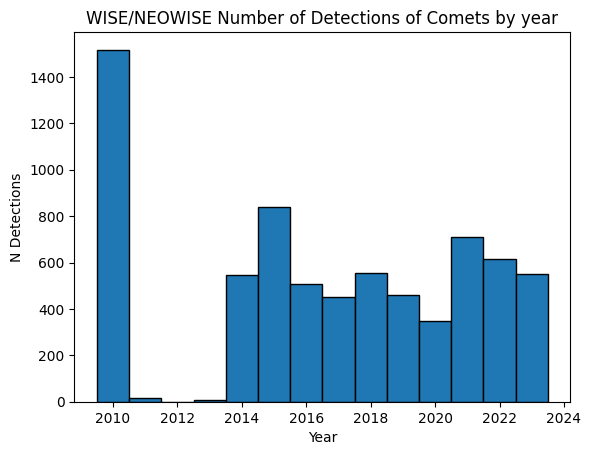

In [2]:
comet_obs = load_mpc_observations()

from matplotlib import rcParams
rcParams['patch.force_edgecolor'] = True

plt.hist([neospy.Time(c.jd).ymd[0] for c in comet_obs],
         bins=np.arange(2009.5, 2024.5),
         histtype='bar',
         edgecolor='black',
         linewidth=1)

plt.xlabel("Year")
plt.ylabel("N Detections")
plt.title("WISE/NEOWISE Number of Detections of Comets by year")

# JPL Orbit Metadata

And keep selection

In [3]:
keep = load_keep_list()

jpl_metadata = load_comet_orbit_metadata()
all_comet_desigs = set(jpl_metadata.desig)

Text(0.5, 1.0, 'All Comet heliocentric distances over WISE Phases')

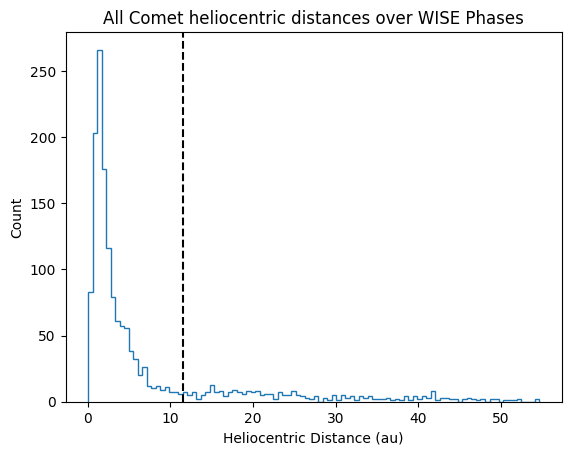

In [4]:
min_dists = {}
for name in filter_names_using_horizons(all_comet_desigs, min_dist=1100):
    obj = neospy.HorizonsProperties.fetch(name, exact_name=True)
    
    state = obj.state
    
    d_min = 1000
    for jd in np.arange(jd_start, jd_end, 20):
        if neospy.wise.mission_phase_from_jd(jd) is None:
            continue
        d = neospy.propagate_two_body([state], jd)[0].pos
        d = (neospy.SpiceKernels.state("Earth", jd).pos - d).r
        if d < d_min:
            d_min = d
    min_dists[name] = d_min
plt.hist(min_dists.values(), bins=100, histtype='step');
# plt.xscale('log')
plt.xlabel("Heliocentric Distance (au)")
plt.ylabel("Count")
plt.axvline(11.5, c='k', ls='--')
plt.title("All Comet heliocentric distances over WISE Phases")

# NEOSpy field of view checks

In [5]:
vis = load_vis()

In [6]:
from collections import defaultdict

mpc_by_names = defaultdict(list)
for obs in comet_obs:
    mpc_by_names[obs.name].append(obs)
mpc_by_names = dict(mpc_by_names)
        
vis_by_names = defaultdict(list)
for states in vis:
    for state in states:
        vis_by_names[state.desig].append((state, states.fov))
vis_by_names = dict(vis_by_names)

In [7]:
len(comet_obs)

7125

In [8]:
# Make sure all mpc names are a subset of the visible list
# if this is an empty set(), then all MPC submitted objects were present in the simulation
set(mpc_by_names.keys()).difference(vis_by_names.keys())

set()

In [9]:
# Make sure all mpc names are a subset of the keep list
set(mpc_by_names.keys()).difference(keep)

set()

In [10]:
# Make sure all visible names are a subset of the keep list
set(vis_by_names.keys()).difference(keep)

set()

In [11]:
ras = []
decs = []
all_matches = []
missed = []

for name in keep:
    meas = mpc_by_names.get(name, [])
    expected = vis_by_names[name]
    matching = []
        
    for m in meas:
        for state, fov in expected:
            if abs(m.jd - fov.observer.jd + 4 / 60 / 60 / 24) < 6e-5:
                matching.append([m, state, fov])
                break
        else:
            missed.append(m)
            matching.append([m, None, None])
            
    for obs, state, fov in matching:
        if state is None:
            continue
        all_matches.append((obs, state, fov))
        vec = (state.pos - fov.observer.pos).as_equatorial
        ras.append((vec.ra - obs.ra) * 60 * 60)
        decs.append((vec.dec - obs.dec) * 60 * 60)
        

In [12]:
len(missed)

0

In [13]:
np.max(np.abs(ras)), np.max(np.abs(decs))

(35.57662835837618, 17.31091455639291)

In [14]:
len(all_matches), sum(np.abs(ras) > 10), sum(np.abs(decs) > 10)

(7125, 54, 9)

Text(0, 0.5, 'Count')

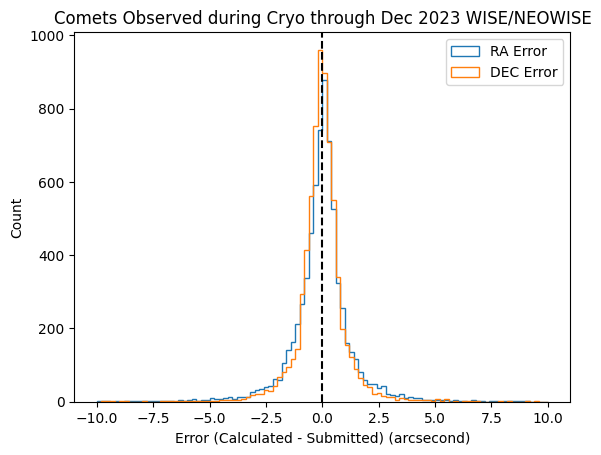

In [15]:
plt.title("Comets Observed during Cryo through Dec 2023 WISE/NEOWISE")
plt.hist(np.array(ras), bins=np.linspace(-10, 10, 101), histtype='step', label='RA Error');
plt.hist(np.array(decs), bins=np.linspace(-10, 10, 101), histtype='step', label='DEC Error');
plt.xlabel("Error (Calculated - Submitted) (arcsecond)")
plt.axvline(0.0, c='k', ls='--')
plt.legend()
plt.ylabel("Count")

# Single Observation Checks

Text(0.5, 0.98, 'MPC Submission')

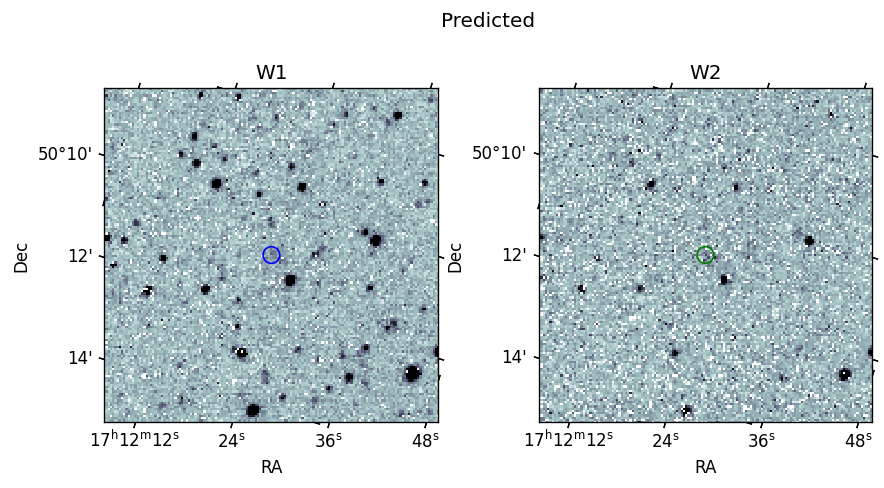

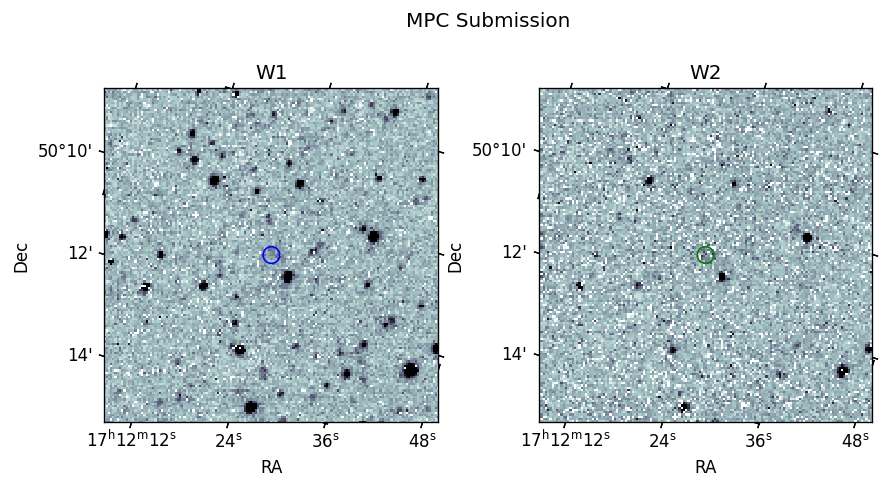

In [18]:
obj_name = "C/2017 K2"

v, state, fov = [[m, s, f] for m, s, f in all_matches if m.name == obj_name][0]

neospy.wise.plot_frames(fov.scan_id, fov.frame_num, v.ra, v.dec, zoom=True)
plt.suptitle("Predicted")

vec = (state.pos - fov.observer.pos).as_equatorial
neospy.wise.plot_frames(fov.scan_id, fov.frame_num, vec.ra, vec.dec, zoom=True)
plt.suptitle("MPC Submission")

# Validating MPC Observations

In [19]:
# Find where there are multiple observations for the same JD
jds = [k for k, v in zip(*np.unique([o.jd for o in comet_obs], return_counts=True)) if v > 1]

In [20]:
# Check for repeats
print("\nRepeats:\n")
for jd in jds:
    print("\n\n", neospy.Time(jd).ymd)
    for o in [o for o in comet_obs if o.jd == jd]:
        print(o)


Repeats:



 (2010, 2, 17.475016031875)
MPCObservation(name='356P', discovery=False, note1='', note2='S', jd=2455244.975016032, ra=64.82429166666665, dec=10.940805555555556, mag_band='', obs_code='C51', sun2sc=[-0.8429638255820315, 0.5156716021699366, -2.0523018895628734e-05])
MPCObservation(name='356P', discovery=False, note1='', note2='S', jd=2455244.975016032, ra=64.82422916666665, dec=10.940861111111111, mag_band='', obs_code='C51', sun2sc=[-0.8429638256054276, 0.5156716021389843, -2.05230113048323e-05])


 (2010, 5, 18.319936032407405)
MPCObservation(name='349P', discovery=False, note1='', note2='S', jd=2455334.8199360324, ra=154.65933333333334, dec=7.887944444444444, mag_band='', obs_code='C51', sun2sc=[-0.5489767722521295, -0.8495480882840489, 2.0124997611647648e-05])
MPCObservation(name='349P', discovery=False, note1='', note2='S', jd=2455334.8199360324, ra=154.65922916666668, dec=7.888416666666666, mag_band='', obs_code='C51', sun2sc=[-0.5489767722213804, -0.8495480883095844,

In [23]:
import neospy_old

Loading 1496 spk files...


In [24]:
keep

['100P',
 '101P',
 '102P',
 '103P',
 '104P',
 '105P',
 '106P',
 '108P',
 '10P',
 '110P',
 '111P',
 '112P',
 '113P',
 '114P',
 '115P',
 '116P',
 '117P',
 '118P',
 '119P',
 '11P',
 '120P',
 '121P',
 '123P',
 '124P',
 '125P',
 '126P',
 '127P',
 '128P',
 '129P',
 '12P',
 '130P',
 '131P',
 '132P',
 '134P',
 '135P',
 '136P',
 '137P',
 '138P',
 '139P',
 '13P',
 '140P',
 '141P',
 '142P',
 '143P',
 '144P',
 '145P',
 '146P',
 '147P',
 '148P',
 '149P',
 '14P',
 '150P',
 '151P',
 '152P',
 '154P',
 '155P',
 '156P',
 '157P',
 '158P',
 '159P',
 '15P',
 '160P',
 '161P',
 '162P',
 '163P',
 '164P',
 '168P',
 '169P',
 '16P',
 '170P',
 '171P',
 '172P',
 '173P',
 '175P',
 '177P',
 '178P',
 '179P',
 '17P',
 '180P',
 '181P',
 '182P',
 '183P',
 '184P',
 '185P',
 '186P',
 '187P',
 '188P',
 '189P',
 '190P',
 '191P',
 '192P',
 '193P',
 '194P',
 '195P',
 '196P',
 '197P',
 '198P',
 '199P',
 '19P',
 '200P',
 '201P',
 '202P',
 '203P',
 '204P',
 '205P',
 '206P',
 '207P',
 '208P',
 '209P',
 '210P',
 '211P',
 '212P',
 

In [27]:
with open("old/keepers.txt", "r") as f:
    old = [s.strip().upper() for s in f.readlines()]

In [33]:
with open("old/difference.txt", "w") as f:
    f.writelines("\n".join(sorted(list(set(old).difference(keep)))))

In [43]:

def filter_names_using_horizons(desigs, pos_unc=0.01, min_dist=11.5):
    """
    Given a list of designations, lookup the name which horizons prefers for this object.

    This rejects objects with the following properties:
        1) If the covariance of the orbit fit is not specified (typically very bad orbit fits).
        2) If positional uncertainty is greater than `pos_unc` specified.
        3) Reject if the objects minimum distance to the sun during the WISE mission is never
           less than the specified `min_dist`

    This returns a dictionary from the JPL preferred name to the original names provided.
    """

    found_names = {}
    for idx, name in enumerate(desigs):
        if "D/" in name:
            found_names[original_name] = "D/"
            continue
        original_name = name
        try:
            obj = neospy.HorizonsProperties.fetch(name, exact_name=True)
        except:
            prefix, name = name.split("/", maxsplit=1)
            obj = neospy.HorizonsProperties.fetch(name, exact_name=True)

        if obj.covariance is None:
            found_names[original_name] = "No Cov"
            continue
        pos_cov = np.linalg.norm(np.diag(obj.covariance.cov_matrix)[:3])
        if pos_cov > pos_unc:
            found_names[original_name] = "Bad Unc"
            continue
                
        state = obj.state
        
        d_min = 1000
        for jd in np.arange(jd_start, jd_end, 40):
            if neospy.wise.mission_phase_from_jd(jd) is None:
                continue
            d = neospy.propagate_two_body([state], jd)[0].pos
            d = (neospy.SpiceKernels.state("Earth", jd).pos - d).r
            if d < d_min:
                d_min = d
        if d_min > min_dist:
            found_names[original_name] = "Far"
            continue
                
        found_names[name] = "**************************"
    return found_names


In [45]:
diff_names = sorted(list(set(old).difference(keep)))

filter_names_using_horizons(diff_names)

{'109P': 'Far',
 '122P': 'Far',
 '153P': 'Far',
 '165P': 'Far',
 '166P': 'Far',
 '167P': 'Bad Unc',
 '18D': '**************************',
 '1P': 'Far',
 '20D': 'Far',
 '23P': 'Far',
 '25D': '**************************',
 '55P': 'Far',
 '85D': 'Bad Unc',
 'C/1900 B1': 'Far',
 'C/1900 O1': 'Far',
 'C/1901 G1': 'Far',
 'C/1902 R1': 'Far',
 'C/1902 X1': 'Far',
 'C/1903 A1': 'Far',
 'C/1903 M1': 'Far',
 'C/1904 H1': 'Far',
 'C/1905 F1': '**************************',
 'C/1905 W1': 'Bad Unc',
 'C/1905 X1': 'Far',
 'C/1906 B1': 'Far',
 'C/1906 E1': 'Bad Unc',
 'C/1906 V1': 'Far',
 'C/1907 E1': 'Bad Unc',
 'C/1907 G1': 'Bad Unc',
 'C/1907 L2': 'Far',
 'C/1907 T1': 'Bad Unc',
 'C/1908 R1': 'Far',
 'C/1909 L1': 'Far',
 'C/1910 A1': 'Far',
 'C/1910 P1': 'Bad Unc',
 'C/1911 N1': 'Far',
 'C/1911 S2': 'Far',
 'C/1912 R1': 'Far',
 'C/1913 J1': 'Far',
 'C/1913 Y1': 'Far',
 'C/1914 F1': 'Far',
 'C/1914 J1': 'Far',
 'C/1914 M1': 'Bad Unc',
 'C/1914 S1': 'Bad Unc',
 'C/1915 C1': 'Far',
 'C/1915 R1': 'Bad 

In [47]:
old = neospy_old.binary.load_packed_file("old/Cryo-comets.bin")

In [100]:
state = old[15]
print(state[0].desigs[0].upper())
np.array(state[0][0].pos[0])

P/2021 N1


array([-3.72933223,  0.39792546, -0.6062894 ])

In [101]:
(vis_by_names[state[0].desigs[0].upper()][0][0].pos - np.array(state[0].pos[0])).r

3.841106552478717e-07

In [54]:
(2455203.5832690196 - 2455203.583319885) * 60 * 24 * 60

-4.394786059856415

In [102]:
1e-7 * neospy.constants.AU_KM

14.959787069999997